## MNIST Exploration
#### Hands-On ML Chapter 3

### NOTE: X is the data, y is the target class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
y.shape

(70000,)

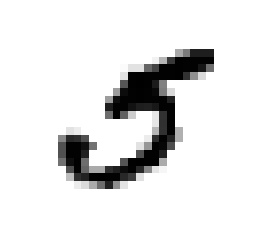

In [5]:
% matplotlib inline
import matplotlib

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000]

5.0

sklearn provides built in data sets, one of which is a bunch of images of written numbers. You can see that we used matplotlib's imshow() function to display an image of the number. It's a 28x28 image, so there's 784 pieces of data per each column (0, 255) each representing a shade of black and white. This data set is already split up into a training and test sets for us.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
X_train[[30012, 1]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Aurelien uses numpy's random permutation function here. Some explanation: if you call X_train by itself, it will display the array in a default order. If you provide a list of indeces, it will provide the rows that you asked for in the specified order. Thus, when we run random permutation, we get a list of 60000 shuffled numbers, and then we pass that as an argument to the array, which then returns a different array based on the shuffled list, which we save into a variable. The permutation function does not shuffle it inplace. Sklearn also provides a shuffle function that does not affect the original array, but numpy has its own shuffle function that will simply do it in place. It will modify the original array.

The sklearn shuffle is in sklearn.utils

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5) # These are the target classifications for each image

Above, we're creating target classifications as either 5 or not-5, thus, a binary classifier. 

Aurelien wants us to use a stochastic gradient descent in order to classify images. This is a classifier that orbits around the middle term 'gradient'. Gradient is issentially the slope of a function in terms multivariable calculus. This means that it it represents the slope as a vector. From Wikipedia, "...the gradient points in the direction of the greatest rate of increase of the function, and its magnitude is the slope of the graph in that direction." Descent describes a method of searching for values using the gradient, and stochastic is a stipulation to this function on how samples are taken and how to iterate through them. There is also batch gradient descent. In sum, stochastic gradient descent is an algorithm to find the max or min of a function using the gradient of that function using sample subsets and fewer iterations. Aurelien will talk about this in more detail later, and it will be discussed in multivariable calculus (calculus III).

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [12]:
sgd_clf.predict([some_digit])
y[36000]

5.0

I needed to take a second to wrap my head around what we did here. We passed the array of values and a list of booleans to the classifier. We're not explicitly telling the classifier what a 5 is. In this instance, we're just passing booleans, and guesses if something is true or false based on the arrangement of the pixels. We can make another list of booleans based on whichever number we wanted and do the same thing. 

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95775
0.93875
0.96435


Aurelien demonstrates here that it's relatively easy to implement your own version of cross_val_score. sklearn has a nice stratifiedkfold class that does everything in its name: it stratifies the sample(I'm not really sure how it goes about determing how to stratify it), and it divides the data into 3 sets (you can pass n_splits into it, but the default is 3, which is what we wanted). When we run the split method of this class on the X-train and y-train-5 sets, it returns an ndarray of indices where to split the training and test partitions, this case, 3 sets of indices. We then clone our previous SGD classifier (this just clones the classifier we instantiated without fitting it to any data). We put the split groups into variables, which we then fit and predict(using the test data) using our classifier and returns a proportion of the number of correct predictions.

### .split() returns a generator consisting of a tuple of numpy arrays containing the test and train indices.

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.95775,  0.93875,  0.96435])

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90875,  0.90975,  0.91045])

We made a stupid classifier of the base estimator and it was almost just as accurate as our other model since only about 10% of the images 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. This qualifies as a *skewed dataset*, since some classes are more frequent than others.

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict returns the prediction of a particular row in the data when that row was in the test set. In this case, X_train has 60000 images in it, and we have 3 folds. So, for 3 iterations, 20000 pieces of data are in the test set, and the rest are in the training set. Whereas cross_val_score returned the proportion of correct predictions, this just returns the prediction outright. So we have an array of 60000 predictions.

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53843,   736],
       [ 2047,  3374]])

In [32]:
#### Illustration of Confusion Matrix

pd.DataFrame(np.array([[53843, 736], [2047, 3374]]),
             columns=['predicted non-5', 'predicted 5'],
             index=['actual non-5', 'actual 5'])

,predicted non-5,predicted 5
actual non-5,53843,736
actual 5,2047,3374


first row = negative class

second row = positive class

first column, first row = true negatives

second column, first row = false positives

first column, second row = false negatives

second column, second row = true positives

### Precision

$$precision = \frac{TP}{TP + FP}$$

TP = # True Positives
FP = # False Positives

Number of correctly identified 5s divided by total number of images predicted as 5

### Recall

$$recall = \frac{TP}{TP + FN}$$

FN = # False Negatives

Number of correctly identified 5s divided by the total number of 5s